# 🙋‍♂️ Вступление

Добрый день(вечер, утро, ночь), здравствуйте! Проектная работа из ЯндексПрактики. Первые шаги в машинном обучении. В данной работе построены модели предсказания LogisticRegression и RandomForest. Сделана кластеризация на основе дендрограммы. Использованы библиотеки: pandas, numpy, sklearn, scipy, matplotlib, seaborn.

**Бриф.**

Получены данные фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

**Задача** 

- составить модели предсказания и кластеры
- портрет клиента
- выяснить какие факторы влияют на отток клиента
- дать рекомендации по возможной стратегии уменьшения оттока клиентов

# 📚 1. Импорт

In [ ]:
# нужен для отображения значений над bar в графике
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.0 MB/s 
     |████████████████████████████████| 957 kB 54.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# 🏋 2. Загрузка файла

In [ ]:
try:
  df = pd.read_csv('/content/gym_churn.csv')
except:
  df = pd.read_csv('/datasets/gym_churn.csv')

In [ ]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.2275,5.0000,3,0.0204,0.0000,0
1,0,1,0,0,1,12,1,31,113.2029,12.0000,7,1.9229,1.9102,0
2,0,1,1,0,1,1,0,28,129.4485,1.0000,2,1.8591,1.7365,0
3,0,1,1,1,1,12,1,33,62.6699,12.0000,2,3.2056,3.3572,0
4,1,1,1,1,1,1,0,26,198.3623,1.0000,3,1.1139,1.1201,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

- 14 колонок
- 4000 строк
- только числовые значения
- пропусков нет

# 💡 3. Описание данных и предобработка

> Данные клиента за предыдущий до проверки факта оттока месяц:

- '**gender**' — пол;
- '**Near_Location**' — проживание или работа в районе, где находится фитнес-центр;
- '**Partner**' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- '**Phone**' — наличие контактного телефона;
- '**Age**' — возраст;
- '**Lifetime**' — время с момента первого обращения в фитнес-центр (в месяцах).

> Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- '**Contract_period**' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- '**Month_to_end_contract**' — срок до окончания текущего действующего абонемента (в месяцах);
- '**Group_visits**' — факт посещения групповых занятий;
- '**Avg_class_frequency_total**' — средняя частота посещений в неделю за все время с начала действия абонемента;
- '**Avg_class_frequency_current_month**' — средняя частота посещений в неделю за предыдущий месяц;
- '**Avg_additional_charges_total**' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- '**Churn**' — факт оттока в текущем месяце.

- В таблице встречаются строчные и заглавные названия колонок, приведем все значнеия в нижний регистр. Заодно уберем пробелы если они есть.

In [ ]:
df.columns = df.columns.str.replace(' ', '').str.lower()

In [ ]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.2275,5.0000,3,0.0204,0.0000,0
1,0,1,0,0,1,12,1,31,113.2029,12.0000,7,1.9229,1.9102,0
2,0,1,1,0,1,1,0,28,129.4485,1.0000,2,1.8591,1.7365,0
3,0,1,1,1,1,12,1,33,62.6699,12.0000,2,3.2056,3.3572,0
4,1,1,1,1,1,1,0,26,198.3623,1.0000,3,1.1139,1.1201,0


## 3.1 Проверка на дубликаты

In [ ]:
df.duplicated().sum()

0

- Явные дубликаты отсутствуют. В теории было возможно совпадение, что не озночало бы, что данные являются дублем, просто ходит брат близнец.

## 3.2 Поиск аномальных значений

- Изучим отдельно булевы и остальные значения.

### 3.2.1 Описане булевых значений таблицы

In [ ]:
df_bool = df[['gender', 'near_location', 'partner', 'promo_friends', 'phone',
    'group_visits', 'churn']]

In [ ]:
df_bool.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0000,0.5102,0.5000,0.0000,0.0000,1.0000,1.0000,1.0000
near_location,4000.0000,0.8452,0.3617,0.0000,1.0000,1.0000,1.0000,1.0000
partner,4000.0000,0.4868,0.4999,0.0000,0.0000,0.0000,1.0000,1.0000
promo_friends,4000.0000,0.3085,0.4619,0.0000,0.0000,0.0000,1.0000,1.0000
phone,4000.0000,0.9035,0.2953,0.0000,1.0000,1.0000,1.0000,1.0000
group_visits,4000.0000,0.4123,0.4923,0.0000,0.0000,0.0000,1.0000,1.0000
churn,4000.0000,0.2652,0.4415,0.0000,0.0000,0.0000,1.0000,1.0000


- в наш фитнес ходят почти поровну мужчин и женщин, в основном те кто живет рядом 84%
- чуть меньше половины 48% ходят используя партнерские программы, 30% пришли по акции "приведи друга"
- 10% не оставили своего номера, 41% ходит на групповые занятия
- около 26.5% ушли от нас

### 3.2.2 Описане других значений таблицы

In [ ]:
df_other = df[['contract_period', 'age','avg_additional_charges_total', 
    'month_to_end_contract', 'lifetime',
    'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']]

In [ ]:
df_other.describe().T

,count,mean,std,min,25%,50%,75%,max
contract_period,4000.0000,4.6813,4.5497,1.0000,1.0000,1.0000,6.0000,12.0000
age,4000.0000,29.1842,3.2584,18.0000,27.0000,29.0000,31.0000,41.0000
avg_additional_charges_total,4000.0000,146.9437,96.3556,0.1482,68.8688,136.2202,210.9496,552.5907
month_to_end_contract,4000.0000,4.3228,4.1913,1.0000,1.0000,1.0000,6.0000,12.0000
lifetime,4000.0000,3.7247,3.7493,0.0000,1.0000,3.0000,5.0000,31.0000
avg_class_frequency_total,4000.0000,1.8790,0.9722,0.0000,1.1809,1.8328,2.5361,6.0237
avg_class_frequency_current_month,4000.0000,1.7671,1.0529,0.0000,0.9630,1.7196,2.5103,6.1468
churn,4000.0000,0.2652,0.4415,0.0000,0.0000,0.0000,1.0000,1.0000


- в среднем абонемент покупают на 5 месяцев, причем мы имеем большое std в 5 месяцев
- к нам ходят клиенты средний возраст 29 лет, самый молодой 18 лет, тот что постарше 41 годик. Почти каждый найдет себе ровестника std всего 3 года.
- каждый в среднем приносит по 147(дол.) помимо стоимости абонемента, std 96(дол.)
- 4 месяца занятий в запасе, отлично! правда есть и те у кого он закончился std 4
- наш средне статистический спортсмен тренeруется 4 месяца, очень мало, за 4 месяца даже подтягиваться не научишься. std 4
- а ходит он 2 раза в неделю (по хорошему надо раза 3), при std в 1
- в показателе хождения в неделю по пред месяцу, все почти так же.

## 3.3 Средние значения признаков по **Churn**

- Создадим сводную таблицу с группировкой по факту оттока где 0 остался, 1 ушел. 
- Посчитаем разницу между группами 0 и 1(diff), чтобы выявить где есть изменения.

In [ ]:
t = df.groupby(["churn"]).mean().T.rename(columns={0: 'stay', 1: 'leave'}).sort_values(by='stay')
t['diff'] = t['stay'] - t['leave']
t.sort_values(by='diff')

churn,stay,leave,diff
gender,0.5100,0.5108,-0.0008
phone,0.9037,0.9029,0.0008
near_location,0.8731,0.7681,0.1049
promo_friends,0.3535,0.1838,0.1697
partner,0.5342,0.3553,0.1789
group_visits,0.4641,0.2686,0.1955
avg_class_frequency_total,2.0249,1.4750,0.5499
avg_class_frequency_current_month,2.0279,1.0445,0.9833
age,29.9765,26.9896,2.9869
month_to_end_contract,5.2831,1.6626,3.6205


- те кто живет дальше от фитнеса, уходят чаще.
- те кто приходит от друзей чаще остаются, как и те кто одит от партнеров.
- групповые занятия позитивно влияют на то что человек останется
- те кто ушел, реже ходили в зал
- молодые уходят чаще, но не факт
- чем меньше осталось абонемента, тем чаще уходят.
- чаще уходят те кто недавно пришел 
- те кто остался чаще пользуются доп услугами фитнеса

## 3.4 Визуализация признаков по **Churn**

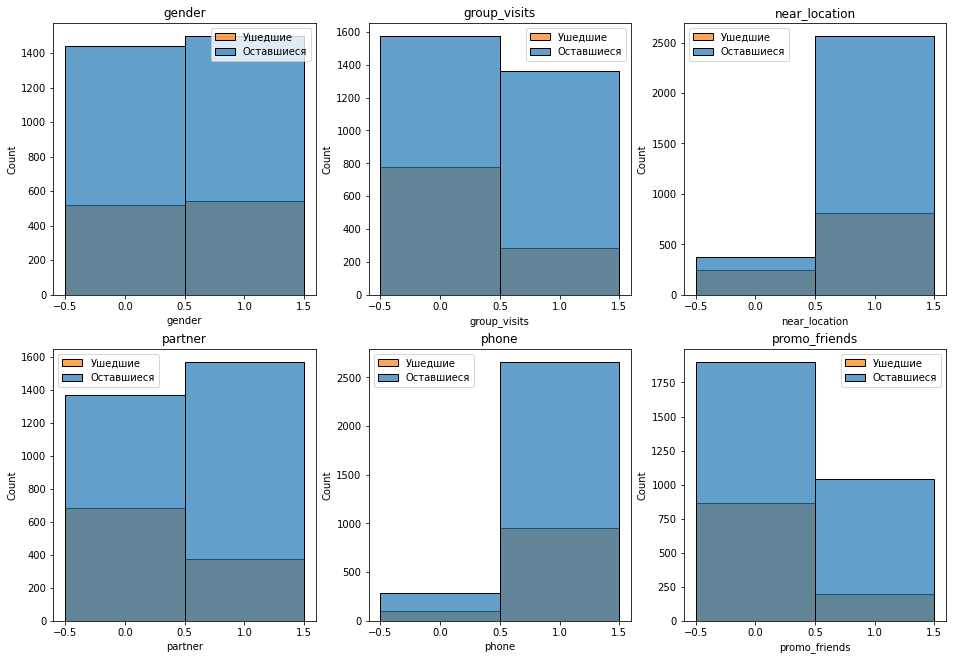

In [ ]:
cat_columns = df_bool.drop(columns=['churn'])


plt.figure(figsize=(16,11))
for i, column in enumerate(sorted(cat_columns)):
    plt.subplot(2,3,i+1)
    plt.title(column)
    sns.histplot(df, x=column, hue='churn', discrete=True, alpha=0.7)
    plt.legend(['Ушедшие', 'Оставшиеся'])
plt.show()


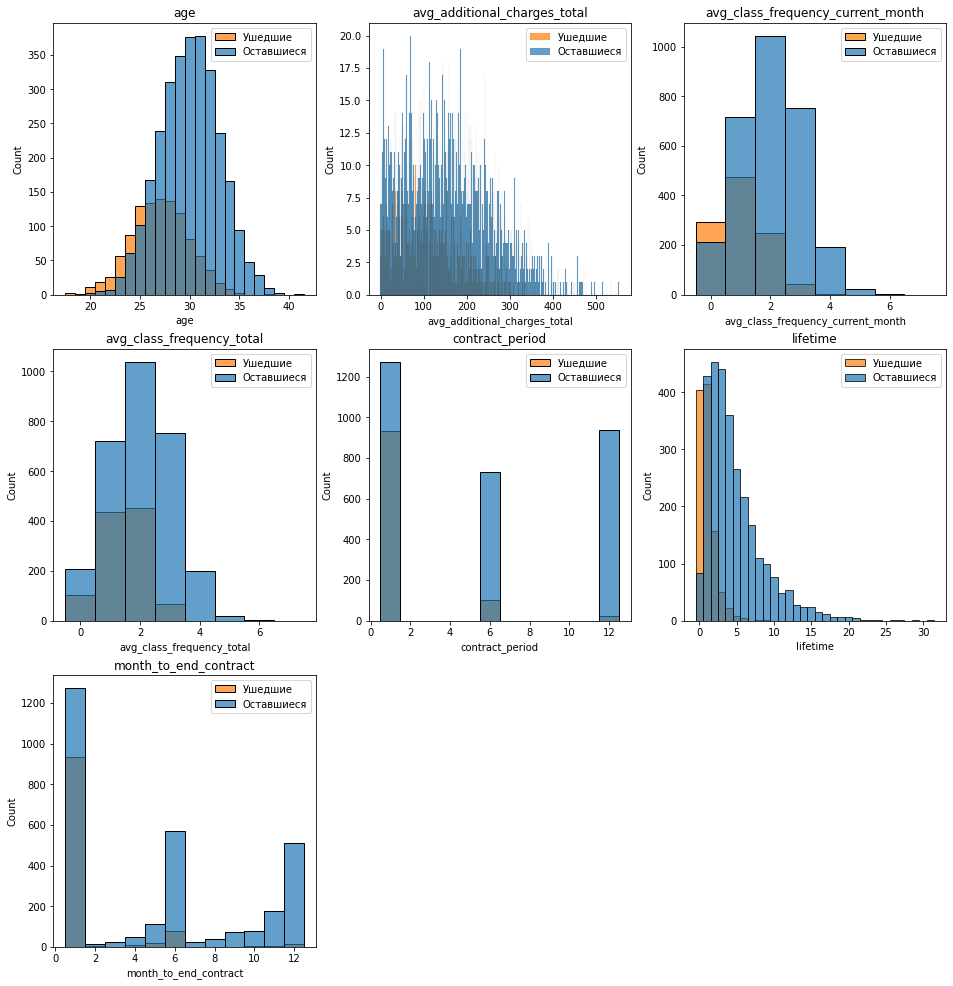

In [ ]:
num_columns = df_other.drop(columns=['churn'])


plt.figure(figsize=(16,17))
for i, column in enumerate(sorted(num_columns)):
    plt.subplot(3,3,i+1)
    plt.title(column)
    sns.histplot(df, x=column, hue='churn', discrete=True, alpha=0.7)
    plt.legend(['Ушедшие', 'Оставшиеся'])
plt.show()

## 3.5 Pearson Correlation

- Разделим таблицу наглядности, в каждой таблице оставим целевую переменную churn

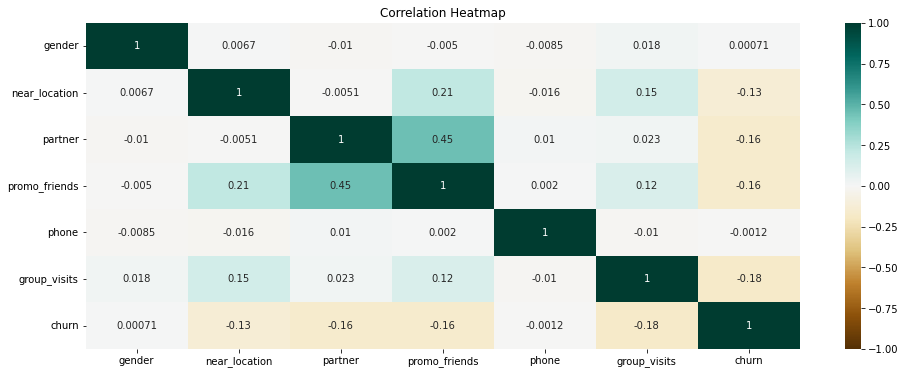

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_bool.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap')
plt.show()

- связь между партнерами и акцией приведи друга
- связи с целевой перменной не обнаружено.

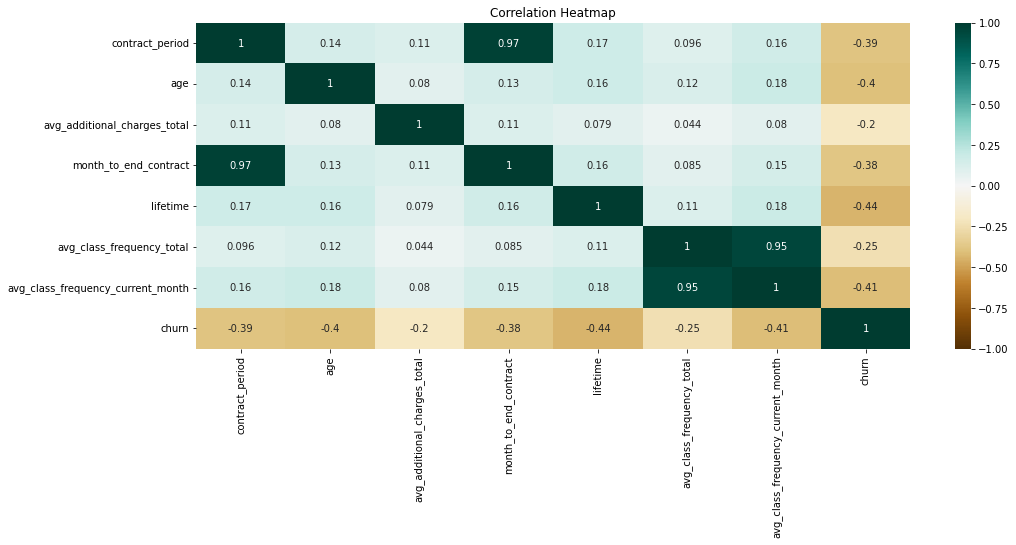

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_other.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap')
plt.show()

- наблюдется сабая отрицательная свзять между churn и всеми другим метриками
- сильная связь между посещениями в неделю и всеми посещениями, удалим колонку avg_class_frequency_current_month для лучшего построения модели
- связь между концом абонемента и текущим абонементом, удалим колонку для лучшего построения модели month_to_end_contract

In [ ]:
df = df.drop(columns=['avg_class_frequency_current_month', 'month_to_end_contract'])
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.2275,3,0.0204,0
1,0,1,0,0,1,12,1,31,113.2029,7,1.9229,0
2,0,1,1,0,1,1,0,28,129.4485,2,1.8591,0
3,0,1,1,1,1,12,1,33,62.6699,2,3.2056,0
4,1,1,1,1,1,1,0,26,198.3623,3,1.1139,0


# 💻 4. Построение модели прогнозирования оттока клиентов

## 4.1 Деление и обучение

In [ ]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'], axis=1)
y = df['churn']

In [ ]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

## 4.2 LogisticRegression и RandomForest

In [ ]:
# вывод метрик классификации

def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [ ]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=42)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.84
	Recall: 0.79
Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.84
	Recall: 0.76


- модель логической регрессии показала себя лучше

# 👩‍👩‍👧‍👧 5. Кластеризация

## 5.1 Стандартизируем данные

In [ ]:
# создаём объект класса scaler
scaler = StandardScaler()

In [ ]:
# обучаем нормализатор и преобразуем набор данных 
x_sc = scaler.fit_transform(df.drop(columns=['churn'])) 

## 5.2 Дендограмма

In [ ]:
linked = linkage(x_sc, method = 'ward')

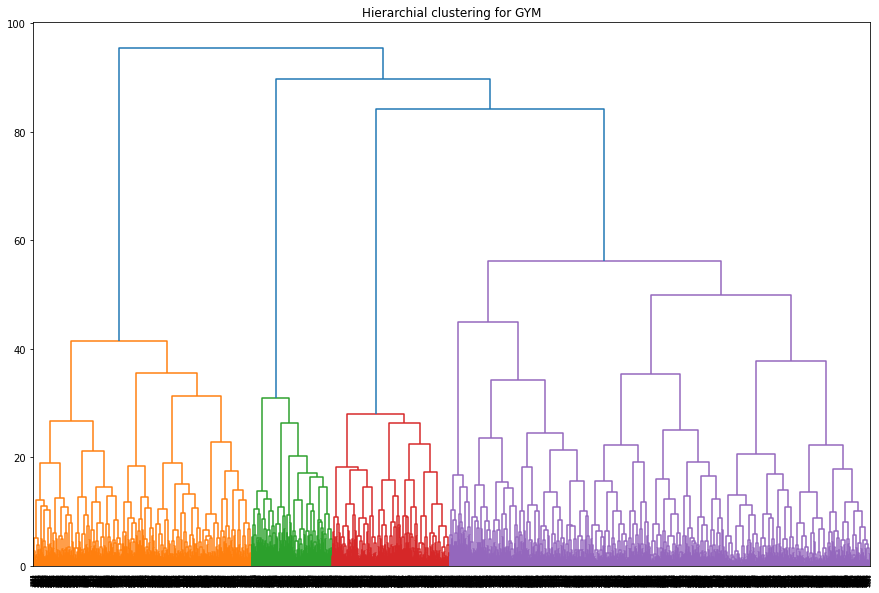

In [ ]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

- исходя из дендограммы можно все разделить на 5 кластеров

## 5.3 Применяем алгоритм K-Means

In [ ]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=42)

In [ ]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

## 5.4 Cредние значения признаков для кластеров

- Рассмотрим кластеры с самым маленьким оттоком и самым большим
- Не берем во внимание категории, где значения у всех кластеров одинаковое.

In [ ]:
df['cluster_churn'] = labels

In [ ]:
df.groupby('cluster_churn').agg('mean').reset_index().T.sort_values(by=[1])

,0,1,2,3,4
churn,0.3826,0.1131,0.2209,0.2668,0.3993
gender,0.5040,0.4961,0.5415,0.5233,0.4991
group_visits,0.0000,0.4987,1.0000,0.4275,0.2353
promo_friends,0.0620,0.8186,0.0881,0.3057,0.0766
partner,0.2347,0.9606,0.1660,0.4715,0.4884
near_location,1.0000,0.9956,1.0000,0.8627,0.0000
cluster_churn,0.0000,1.0000,2.0000,3.0000,4.0000
phone,1.0000,1.0000,1.0000,0.0000,1.0000
avg_class_frequency_total,1.7985,1.9744,1.9462,1.8542,1.7704
lifetime,3.3118,4.3620,3.7612,3.9404,3.0606


> Меньше всего оттока в 1 кластере, больше всех в 0 и 4. Для уменьшения оттока клиентов, необходимо обязательно проводить **групповые занятия**, а так же стараться вовлекать клиентов в этот процесс. Особое внимание нужно уделить акции **"приведи друга"**, эта акция работает, причем она сильно влияет на то что клиент остается с нами. Клиентов стоит искать среди фирм партнеров, от них приходят скорее все те кто останется с нами надолго. Расстояние от фитнес-зала оказывает влияние, но не является решающим фактором. Можно сделать утверждение что те кто живет рядом уходят от нас реже, но и те кто живет далеко не означает что они уйдут от нас. 

## 5.5 Распределения признаков по кластерам

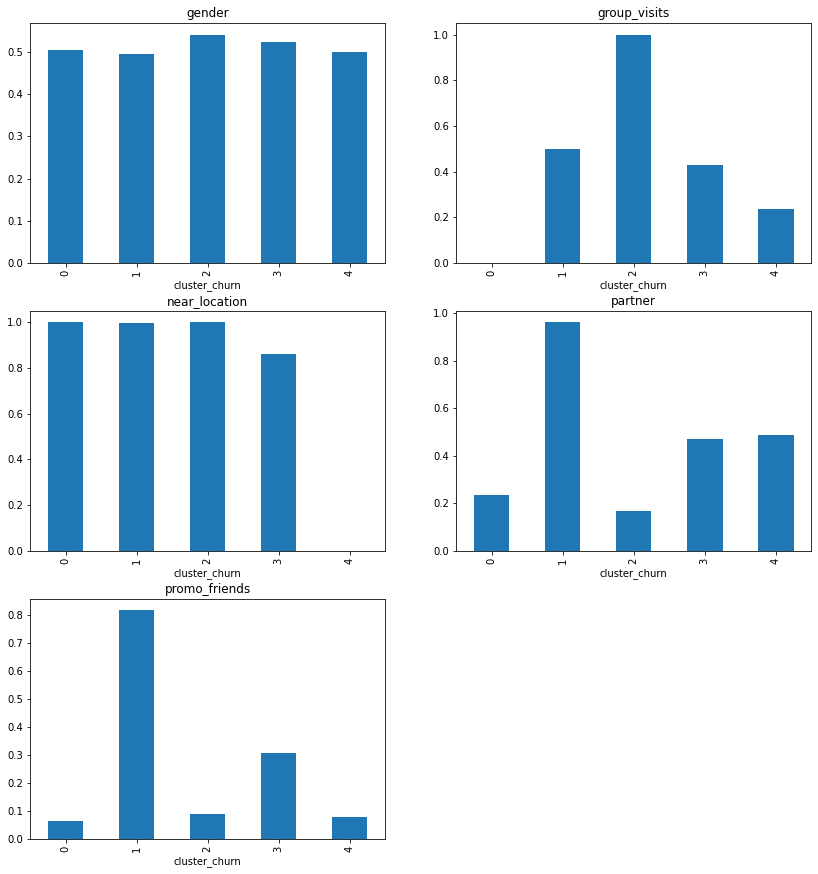

In [ ]:
# категории
cat_columns = ['gender', 'near_location', 'partner', 'promo_friends',
       'group_visits']

plt.figure(figsize=(14,15))
for i, column in enumerate(sorted(cat_columns)):
  plt.subplot(3,2,i+1)
  df.groupby('cluster_churn')[column].mean().plot(kind='bar')
  plt.title(column)
plt.show()

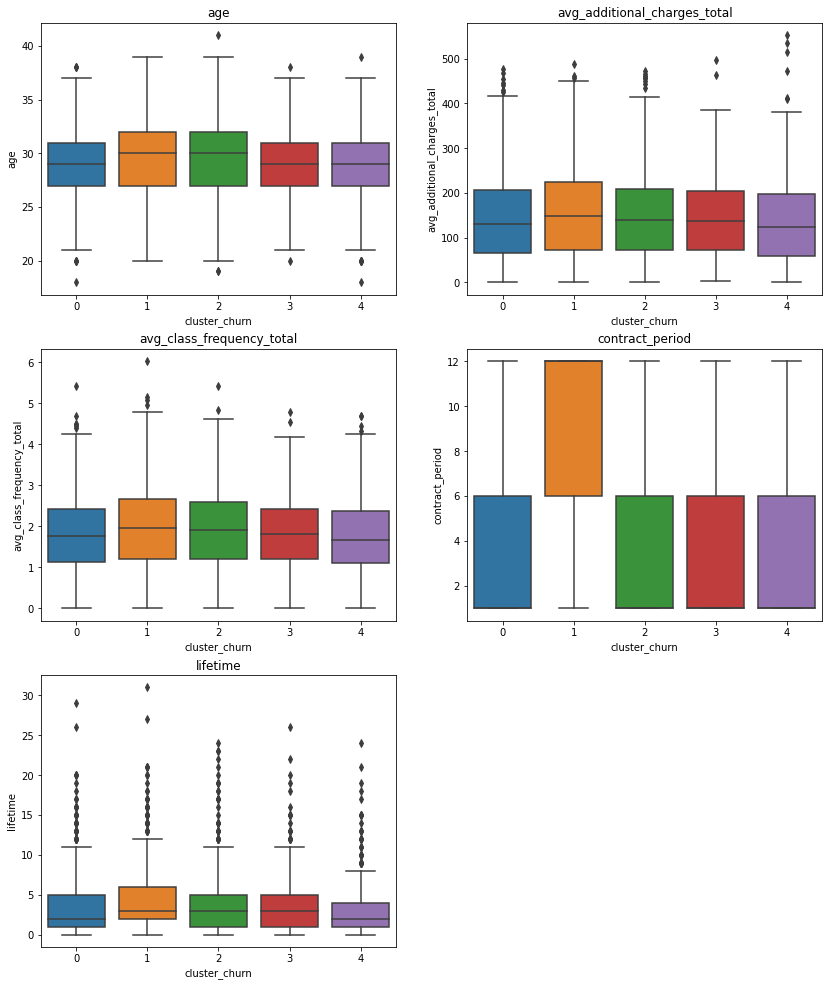

In [ ]:
# числовые

num_columns = ['contract_period',  'age',
              'avg_additional_charges_total', 'lifetime', 
              'avg_class_frequency_total',]

plt.figure(figsize=(14,17))
for i, column in enumerate(sorted(num_columns)):
  plt.subplot(3,2,i+1)
  sns.boxplot(x="cluster_churn", y=column, data=df)
  #df.groupby('cluster_churn')[column].mean().plot(kind='bar')
  plt.title(column)
plt.show()


## 5.6 Доля оттока по кластерам

In [ ]:
# Функции графиков

def multivariate_plot(df=df, x=None, y=None, hue=None, xlabel=None, ylable=None,
                      heading=None, rotation=None, bar_label=True, 
                      legend=False, rotate_label=False):
    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    df = round((df.groupby(x)[y].mean().sort_values().reset_index()),2)

    sns.barplot(data=df, x=x, y=y, hue=hue, ci=None)

    plt.ylabel(ylabel=ylable, size=12)
    plt.xlabel(xlabel=xlabel, size=12)
    plt.title(label=f'{heading} {xlabel}', size=16)
    plt.xticks(rotation=rotation)
    if legend:
        plt.legend()
    if bar_label and rotate_label:
        ax.bar_label(ax.containers[0], label_type='edge', size=10, padding=3, 
                    color="#7f7f7f", rotation="vertical")
    elif bar_label and not rotate_label:
        ax.bar_label(ax.containers[0], label_type='edge', size=12, padding=1, 
                    color="#7f7f7f")
    sns.despine(bottom=True, left=True)
    plt.show()

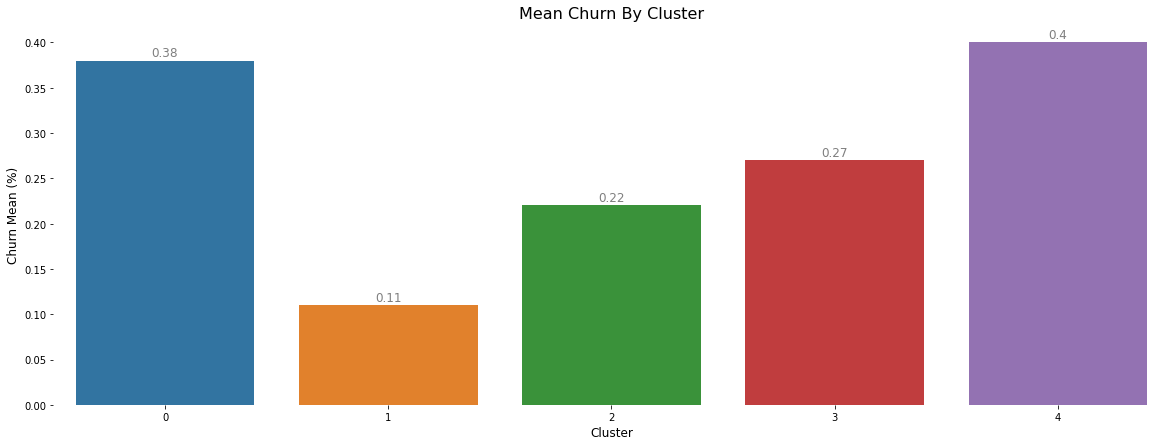

In [ ]:
multivariate_plot(
    df=df, x="cluster_churn", y="churn", 
    xlabel="Cluster", ylable="Churn Mean (%)", 
    heading="Mean Churn By", bar_label=True
    )

- самый большой отток в 0 b 4 кластерах
- меньше всего оотока в 1 кластере

# 📝 6. Выводы и рекомендации

## 6.1 Портрет клиента
 
- В наш фитнес ходят почти поровну мужчин и женщин, в основном те кто живет рядом 84%. Средний возраст 29 лет, самый молодой 18 лет, тот что постарше 41 годик. Абонемент покупают на 5 месяцев (причем мы имеем большое std в 5 месяцев). Наш среднестатистический клиент тренируется 4 месяца и ходит 2 раза в неделю.
 
- На доп услугах мы зарабатываем с каждого 147(дол.), при этом std высокий 96(дол.), получается, что кто то вообще не пользуется доп. услугами. Чуть меньше половины 48% ходят используя партнерские программы, 30% использовали акцию "приведи друга". 41% ходит на групповые занятия.
 
> **Около 26.5% уходят на совсем.**


## 6.2 Рекомендации
 
-  Меньше всего оттока в 1 кластере, больше всех в 0 и 4. Для уменьшения оттока клиентов, необходимо обязательно проводить **групповые занятия**, а так же стараться вовлекать клиентов в этот процесс. Особое внимание нужно уделить акции **"приведи друга"**, эта акция работает, причем она сильно влияет на то что клиент остается с нами. Клиентов стоит искать среди фирм партнеров, от них приходят скорее все те кто останется с нами надолго. Расстояние от фитнес-зала оказывает влияние, но не является решающим фактором. Можно сделать утверждение что те кто живет рядом уходят от нас реже, но и те кто живет далеко не означает что они уйдут от нас. 
 
**Коротко что делать:**
- групповые занятия
- искать клиентов через фирмы партнеры
- акция приведи друга обязательна
- ориентироваться на тех кто живет рядом, если позволяет бюджет искать везде
- дополнительные услуги должны быть на очень высоком уровне



# 💬 Заключение

- Получены данные фитнес-центров «Культурист-датасаентист», файл состоял из 4000 строк, 14 колонк числового содержания. Ключевым показателем являлся отток клиента **churn**, выражен в виде бинарного показателя. Пропусков а также аномальных показателей не выявлено. Явные дубликаты отсутствуют. На основе первичного анализа составлен портрет клиента.
 
- Стояла задача выяснить какие факторы влияют на отток клиента, а также дать рекомендации по возможно стратегии уменьшения оттока. Для этой цели было решено построить модель прогнозирования оттока клиентов. Были выбраны **LogisticRegression** и **RandomForest**. Модель LogisticRegression показала себя лучше по нескольким пунктам. 

---


 
> Метрики для модели логистической регрессии:
 
- Accuracy: 0.90
- Precision: 0.84
- Recall: 0.79
 
> Метрики для модели случайного леса:

- Accuracy: 0.90
- Precision: 0.84
- Recall: 0.76


---


- Далее проведена кластеризация, на основе дендрограммы было решено сделать 5 кластеров. Нормализовав значения каждого кластера, проведен анализ по его среднему значению. Где выявлено, что у **кластера 1** наименьший процент оттока. При этом выявлен кластер 0 и кластер 4 где процент оттока наибольший.
